# Vårt superprosjekt

## a

We initalize and test the functionality of Qiskit as follows

In [34]:
from qiskit import QuantumCircuit,Aer,assemble, ClassicalRegister,QuantumRegister
from qiskit.visualization import array_to_latex, plot_histogram
import numpy as np
simulator = Aer.get_backend('aer_simulator')

In [14]:
qr = QuantumRegister(1, 'Qreg')
cr = ClassicalRegister(1, 'Creg')

qc = QuantumCircuit()
qc.add_register(qr)
qc.add_register(cr)
#qc.save_statevector()

qc.x(0)
qc.y(0)
qc.z(0)
qc.h(0)
qc.p(np.pi/2, 0)


qc.draw()

┌───┐┌───┐┌───┐┌───┐┌────────┐
  Qreg: ┤ X ├┤ Y ├┤ Z ├┤ H ├┤ P(π/2) ├
        └───┘└───┘└───┘└───┘└────────┘
Creg: 1/══════════════════════════════

Initialize a Bell state by applying Haddamard to G0 and CNOT on G1, using G0 as control gate.

In [38]:
qc_2 = QuantumCircuit()

qr_2 = QuantumRegister(2, 'qreg')
qc_2.add_register(qr_2)

cr_2 = ClassicalRegister(2, 'creg')
qc_2.add_register(cr_2)
qc_2.h(0)
qc_2.cx(0,1)
qc_2.save_statevector()
qc_2.measure(qr_2[0], cr_2[0])
qc_2.measure(qr_2[1], cr_2[1])
qc_2.draw()

┌───┐      statevector ┌─┐   
qreg_0: ┤ H ├──■────────░──────┤M├───
        └───┘┌─┴─┐      ░      └╥┘┌─┐
qreg_1: ─────┤ X ├──────░───────╫─┤M├
             └───┘      ░       ║ └╥┘
creg: 2/════════════════════════╩══╩═
                                0  1

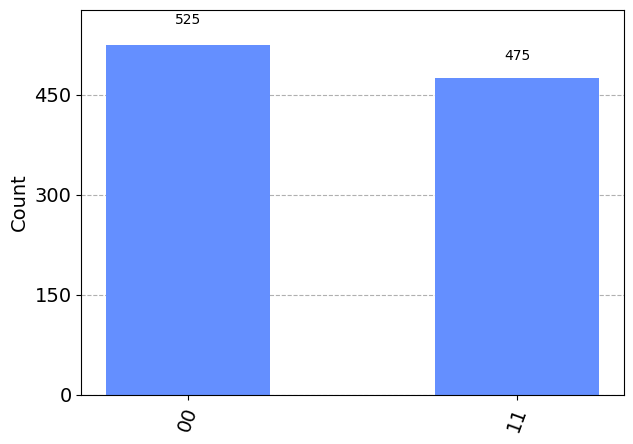

In [37]:
job = simulator.run(qc_2, shots=1000)
hist = job.result().get_counts()
plot_histogram(hist)

This is statistically in accordance with the expected Bell states.

## b


Here we initialize the Hamiltonian matrices and solve it using eigsolvers.


In [73]:
H0 = np.eye(2)
E1 = 0; E2 = 4
H0[0,0] = E1; H0[1,1] = E2


H1 = np.eye(2)
v11 = 3; v22 = -v11; v12 = 0.2; v21 = v12
H1[0,0] = v11; H1[0,1] = v12; H1[1,0] = v21; H1[1,1] = v22 

lmd_ = 2/3#Range [0,1]
pauli_x = np.matrix([[0,1],[1,0]])
pauli_z = np.matrix([[1,0],[0,-1]])
c = (v11 + v22)/2
omega_z = (v11-v22)/2
omega_x = v12

H_ = H0 + lmd_*H1

print(H_)
print()
eig_val, eig_vec = np.linalg.eig(H_)
print(eig_val,'\n\n', eig_vec)

[[2.         0.13333333]
 [0.13333333 2.        ]]

[2.13333333 1.86666667] 

 [[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
